In [1]:
import pandas as pd
from elasticsearch import Elasticsearch, helpers
from pprint import pprint
import uuid

In [2]:
data = pd.read_json('./data/boulder_flood_geolocated_tweets.json', lines=True)
data

created_at                  id              id_str  \
0     2013-12-31 07:14:22+00:00  417916626596806656  417916626596806656   
1     2013-12-31 18:49:31+00:00  418091565161017345  418091565161017344   
2     2013-12-30 20:29:20+00:00  417754295455723520  417754295455723520   
3     2013-12-30 23:02:29+00:00  417792838428925952  417792838428925952   
4     2014-01-01 06:12:15+00:00  418263379027820544  418263379027820544   
...                         ...                 ...                 ...   
18816 2013-09-12 04:12:20+00:00  378008148759420928  378008148759420928   
18817 2013-09-12 04:03:47+00:00  378005998872432640  378005998872432640   
18818 2013-09-12 04:11:56+00:00  378008050335875074  378008050335875072   
18819 2013-09-12 04:05:59+00:00  378006549735538688  378006549735538688   
18820 2013-09-12 04:07:35+00:00  378006955563814912  378006955563814912   

                                                    text  truncated  \
0      Boom bitch get out the way! #drunk #islands #g...      False   
1      @WeatherDude17 Not that revved up yet due to m...      False   
2      Story of my life! 😂 #boulder http://t.co/ZMfNK...      False   
3      We're looking for the two who came to help a c...      False   
4      Happy New Year #Boulder !!!! What are some of ...      False   
...                                                  ...        ...   
18816  RT @EricRobertson: A more representative flood...      False   
18817  Warning. Flash flood of boulder creek is immin...      False   
18818  I just got an “Emergency Alert”! Nice to know ...      False   
18819  RT @dailycamera: RT @CUBoulderPolice:  Some fl...      False   
18820  @monikarun @courtneyo @eatplaylove @Greeblemon...      False   

                                                entities  \
0      {'hashtags': [{'text': 'drunk', 'indices': [28...   
1      {'hashtags': [{'text': 'snow', 'indices': [108...   
2      {'hashtags': [{'text': 'boulder', 'indices': [...   
3      {'hashtags': [{'text': 'Boulder', 'indices': [...   
4      {'hashtags': [{'text': 'Boulder', 'indices': [...   
...                                                  ...   
18816  {'hashtags': [], 'symbols': [], 'user_mentions...   
18817  {'hashtags': [{'text': 'boulderflood', 'indice...   
18818  {'hashtags': [{'text': 'cowx', 'indices': [112...   
18819  {'hashtags': [{'text': 'CUBoulder', 'indices':...   
18820  {'hashtags': [{'text': 'Boulderflood', 'indice...   

                                                  source  \
0      <a href="http://instagram.com" rel="nofollow">...   
1      <a href="https://about.twitter.com/products/tw...   
2      <a href="http://twitter.com/download/iphone" r...   
3      <a href="http://www.tweetcaster.com" rel="nofo...   
4      <a href="http://twitter.com/download/iphone" r...   
...                                                  ...   
18816  <a href="http://www.twitter.com" rel="nofollow...   
18817  <a href="http://twitter.com/download/iphone" r...   
18818  <a href="http://tapbots.com/tweetbot" rel="nof...   
18819  <a href="http://twitter.com/download/iphone" r...   
18820  <a href="http://twitter.com" rel="nofollow">Tw...   

       in_reply_to_status_id  in_reply_to_status_id_str  in_reply_to_user_id  \
0                        NaN                        NaN                  NaN   
1               4.180914e+17               4.180914e+17         1.214464e+09   
2                        NaN                        NaN                  NaN   
3                        NaN                        NaN                  NaN   
4                        NaN                        NaN                  NaN   
...                      ...                        ...                  ...   
18816                    NaN                        NaN                  NaN   
18817                    NaN                        NaN                  NaN   
18818                    NaN                        NaN                  NaN   
18819                    

##### Typecast the dataframe into a list to be indexed

In [3]:
tweets_list = data.values.tolist()

In [4]:
# Take only the coordinates list from ['coordinates'] feature that of type dict
for indx, _ in enumerate(tweets_list):
    if tweets_list[indx][14]:
        tweets_list[indx][14] = tweets_list[indx][14]['coordinates']

In [5]:
tweets_list

[[Timestamp('2013-12-31 07:14:22+0000', tz='UTC'),
  417916626596806656,
  417916626596806656,
  'Boom bitch get out the way! #drunk #islands #girlsnight  #BJs #hookah #zephyrs #boulder #marines… http://t.co/uYmu7c4o0x',
  False,
  {'hashtags': [{'text': 'drunk', 'indices': [28, 34]},
    {'text': 'islands', 'indices': [35, 43]},
    {'text': 'girlsnight', 'indices': [44, 55]},
    {'text': 'BJs', 'indices': [57, 61]},
    {'text': 'hookah', 'indices': [62, 69]},
    {'text': 'zephyrs', 'indices': [70, 78]},
    {'text': 'boulder', 'indices': [79, 87]},
    {'text': 'marines', 'indices': [88, 96]}],
   'symbols': [],
   'user_mentions': [],
   'urls': [{'url': 'http://t.co/uYmu7c4o0x',
     'expanded_url': 'http://instagram.com/p/ik8V-PLAV5/',
     'display_url': 'instagram.com/p/ik8V-PLAV5/',
     'indices': [98, 120]}]},
  '<a href="http://instagram.com" rel="nofollow">Instagram</a>',
  nan,
  nan,
  nan,
  nan,
  None,
  {'id': 430309700,
   'id_str': '430309700',
   'name': 'Dannie

In [6]:
len(tweets_list)

18821

##### Connect to the Elasticsearch cluster

In [7]:
es = Elasticsearch('http://localhost:9200')

In [8]:
index_name3 = 'tweets3'

#####  create a new index in an Elasticsearch cluster

In [9]:
es.indices.create(index=index_name3, ignore=400, body={
    'mappings': {
        'properties':{
            'created_at': {
                'type': 'date'
            },
            'coordinates': {
                'type': 'geo_point'
            },
            'text': {
                'type': 'text'
            }
        }
    }
})

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\4179353297.py:1: DeprecationWarning: Passing transport options in the API method is deprecated. Use 'Elasticsearch.options()' instead.
  es.indices.create(index=index_name3, ignore=400, body={
C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\4179353297.py:1: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  es.indices.create(index=index_name3, ignore=400, body={


ObjectApiResponse({'error': {'root_cause': [{'type': 'resource_already_exists_exception', 'reason': 'index [tweets3/_1kwBwqhTJ6TXcVkvBTMVQ] already exists', 'index_uuid': '_1kwBwqhTJ6TXcVkvBTMVQ', 'index': 'tweets3'}], 'type': 'resource_already_exists_exception', 'reason': 'index [tweets3/_1kwBwqhTJ6TXcVkvBTMVQ] already exists', 'index_uuid': '_1kwBwqhTJ6TXcVkvBTMVQ', 'index': 'tweets3'}, 'status': 400})

##### Populate the index with data

In [10]:
actions = []

for tweet, _ in enumerate(tweets_list):
    
    if tweet % 1000:
        # Add a new document to the "tweets3" index
        actions.append({
            '_index': index_name3,
            '_id': uuid.uuid4().int,
            '_source': {
                "created_at": tweets_list[tweet][0],
                "text": tweets_list[tweet][3],
                "coordinates": tweets_list[tweet][14]
                }
        })
    else:
        helpers.bulk(es, actions)     

In [11]:
if len(actions):
    helpers.bulk(es, actions)

In [12]:
def query_search_score_shown(data_query):
    """Elasticsearch query to show scores along with each resulted source document

    Args:
        data_query (Dict)
    """
    query_result = es.search(
    index = index_name3,
    body=data_query
    )

    pprint(f"max_score = {query_result['hits']['max_score']}")
    print('\n\n\n')
    for hit in query_result['hits']['hits']:
        pprint(f"score = {hit['_score']}")
        pprint(f'_source = {hit["_source"]}')
        print()

In [13]:
def query_search(data_query):
    """Elasticsearch query showing resulted source documents

    Args:
        data_query (Dict)
    """
    query_result = es.search(
    index = index_name3,
    body=data_query
    )

    for hit in query_result['hits']['hits']:
        pprint(hit["_source"])
        print()

In [14]:
def query_search_scored(txt, date_gte, date_lse, coordinates):
    query_result = es.search(
    index = index_name3,
    size=1000,
    body={"query": {
    "bool": {
      "must": [
          {
              "match": {
                  "text": txt
              }
          },
          {
              "range": {
                  "created_at": {
                      "gte": date_gte,
                      "lte": date_lse,
                  }
              }
          },
          {
              "geo_bounding_box": {
                  "coordinates": coordinates
              }
          }
      ]
    }
  }}
    )

    pprint(f"max_score = {query_result['hits']['max_score']}")
    print('\n\n\n')
    for hit in query_result['hits']['hits']:
        pprint(f"score = {hit['_score']}")
        pprint(f'_source = {hit["_source"]}')
        print()

In [15]:
query_all_bounding_box_scored_must = {
  "query": {
    "bool": {
      "must": [
          {
              "match": {
                  "text": "fire"
              }
          },
          {
              "range": {
                  "created_at": {
                      "gte": '2013-07-22T05:21:02+00:00',
                      "lte": '2014-03-19T02:59:18+00:00',
                  }
              }
          },
          {
              "geo_bounding_box": {
                  "coordinates": {
                    "top_left": [
                      -180,
                      79.17133
                    ],
                    "bottom_right": [
                      180,
                      -66.51326
                    ]
                  }
              }
          }
      ]
    }
  }
}

##### create Elasticsearch query that returns tweets matching a text, range date and bounding box location

In [16]:
query_all_bounding_box = {
  "query": {
    "bool": {
      "filter": [
          {
              "match": {
                  "text": "fire"
              }
          },
          {
              "range": {
                  "created_at": {
                      "gte": '2013-07-22T05:21:02+00:00',
                      "lte": '2014-03-19T02:59:18+00:00',
                  }
              }
          },
          {
              "geo_bounding_box": {
                  "coordinates": {
                    "top_left": [
                      -180,
                      79.17133
                    ],
                    "bottom_right": [
                      180,
                      -66.51326
                    ]
                  }
              }
          }
      ]
    }
  }
}

In [17]:
query_search_score_shown(query_all_bounding_box_scored_must)

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


'max_score = 8.930008'




'score = 8.930008'
("_source = {'created_at': '2013-12-18T00:34:06+00:00', 'text': 'Someone just "
 "lit the trash can on fire #productive #boulder', 'coordinates': "
 '[-105.27157763, 40.00630009]}')

'score = 8.930008'
("_source = {'created_at': '2013-12-18T00:34:06+00:00', 'text': 'Someone just "
 "lit the trash can on fire #productive #boulder', 'coordinates': "
 '[-105.27157763, 40.00630009]}')

'score = 8.217127'
("_source = {'created_at': '2013-12-07T02:57:48+00:00', 'text': 'Zero degrees "
 'in #Boulder? Time for a fire and roasting marshmallows. '
 "http://t.co/cEXVbsEaDp', 'coordinates': [-105.24958085, 40.03399171]}")

'score = 8.217127'
("_source = {'created_at': '2013-12-07T02:57:48+00:00', 'text': 'Zero degrees "
 'in #Boulder? Time for a fire and roasting marshmallows. '
 "http://t.co/cEXVbsEaDp', 'coordinates': [-105.24958085, 40.03399171]}")

'score = 8.061249'
("_source = {'created_at': '2013-12-28T02:59:18+00:00', 'text': 'Snuggled up "
 'b

In [18]:
query_search_score_shown(query_all_bounding_box)

'max_score = 0.0'




'score = 0.0'
("_source = {'created_at': '2013-12-28T02:59:18+00:00', 'text': 'Snuggled up "
 'by the fire. #blazing #bright #winter #boulder #colorado #snugglethis '
 "#ineedsmorestuff… http://t.co/YqsHINFICo', 'coordinates': [-105.25598833, "
 '40.01055278]}')

'score = 0.0'
('_source = {\'created_at\': \'2013-12-18T21:43:50+00:00\', \'text\': "We\'ll '
 'be on fire and lookin fly in #Boulder this weekend at the @fireflyhandmade '
 'Holiday Market. Sat &amp; Sun, 10-5, 1600 Pearl St Boulder", '
 "'coordinates': [-104.91267296, 39.72627477]}")

'score = 0.0'
("_source = {'created_at': '2013-12-18T00:34:06+00:00', 'text': 'Someone just "
 "lit the trash can on fire #productive #boulder', 'coordinates': "
 '[-105.27157763, 40.00630009]}')

'score = 0.0'
("_source = {'created_at': '2013-12-07T02:57:48+00:00', 'text': 'Zero degrees "
 'in #Boulder? Time for a fire and roasting marshmallows. '
 "http://t.co/cEXVbsEaDp', 'coordinates': [-105.24958085, 40.03399171]}")



C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [19]:
coordinates_query= {
    "query": {
        "bool": {  
            "filter": {
                "geo_shape": {
                    "coordinates": {
                        "shape": {
                            "coordinates": [
                                -105.22207764, 
                                39.98664341
                            ],
                            "type": "point"
                        },
                    }
                }
            }
        }
    }
}

In [20]:
coordinates_query_scored_must = {
    "query": {
        "bool": {  
            "must": {
                "geo_shape": {
                    "coordinates": {
                        "shape": {
                            "coordinates": [
                                -105.22207764, 
                                39.98664341
                            ],
                            "type": "point"
                        },
                    }
                }
            }
        }
    }
}

In [21]:
query_search_score_shown(coordinates_query_scored_must)

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


'max_score = 0.0'




'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwLrssnvv", \'coordinates\': '
 '[-105.22207764, 39.98664341]}')

'score = 0.0'
("_source = {'created_at': '2013-10-31T03:15:14+00:00', 'text': 'Autumn Days "
 '#colorado #boulder #mountains @ South Boulder Creek Trailhead '
 "http://t.co/XftN3YzETX', 'coordinates': [-105.22207764, 39.98664341]}")

'score = 0.0'
("_source = {'created_at': '2013-09-17T00:40:44+00:00', 'text': 'Out on the "
 'Range #mountains #colorado #boulder #farmlife @ South Boulder Creek '
 "Trailhead http://t.co/HZTSSNhNpS', 'coordinates': [-105.22207764, "
 '39.98664341]}')

'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwL

In [22]:
query_search_score_shown(coordinates_query)

'max_score = 0.0'




'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwLrssnvv", \'coordinates\': '
 '[-105.22207764, 39.98664341]}')

'score = 0.0'
("_source = {'created_at': '2013-10-31T03:15:14+00:00', 'text': 'Autumn Days "
 '#colorado #boulder #mountains @ South Boulder Creek Trailhead '
 "http://t.co/XftN3YzETX', 'coordinates': [-105.22207764, 39.98664341]}")

'score = 0.0'
("_source = {'created_at': '2013-09-17T00:40:44+00:00', 'text': 'Out on the "
 'Range #mountains #colorado #boulder #farmlife @ South Boulder Creek '
 "Trailhead http://t.co/HZTSSNhNpS', 'coordinates': [-105.22207764, "
 '39.98664341]}')

'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwL

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [23]:
date_query = {
  "query": {
      "bool": {
          "must": {
              "range": {
                  "created_at": {
                      "gte": '2013-09-19T11:42:03+00:00',
                      "lte": '2014-04-05T00:10:49+00:00',
                  }
              }
          }
      
      }
  }
}

In [24]:
query_search_score_shown(date_query)

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


'max_score = 1.0'




'score = 1.0'
("_source = {'created_at': '2013-12-31T18:49:31+00:00', 'text': "
 "'@WeatherDude17 Not that revved up yet due to model inconsistency. I\\'d say "
 '0-2" w/ a decent chance of &gt;1" #snow #COwx #weather #Denver\', '
 "'coordinates': None}")

'score = 1.0'
("_source = {'created_at': '2013-12-30T20:29:20+00:00', 'text': 'Story of my "
 "life! 😂 #boulder http://t.co/ZMfNKEl0xD', 'coordinates': [0.13429814, "
 '52.22500698]}')

'score = 1.0'
('_source = {\'created_at\': \'2013-12-30T23:02:29+00:00\', \'text\': "We\'re '
 'looking for the two who came to help a cyclist after a hit-and-run at '
 '30th/Baseline ~11pm Dec 23rd #Boulder #CO http://t.co/zyk3FkB4og", '
 "'coordinates': None}")

'score = 1.0'
("_source = {'created_at': '2014-01-01T06:12:15+00:00', 'text': 'Happy New "
 "Year #Boulder !!!! What are some of your New Years resolutions this year?', "
 "'coordinates': [144.98467167, -37.80312131]}")

'score = 1.0'
("_source = {'created_at': '2013-12

In [25]:
query_search(date_query)

{'coordinates': None,
 'created_at': '2013-12-31T18:49:31+00:00',
 'text': '@WeatherDude17 Not that revved up yet due to model inconsistency. '
         'I\'d say 0-2" w/ a decent chance of &gt;1" #snow #COwx #weather '
         '#Denver'}

{'coordinates': [0.13429814, 52.22500698],
 'created_at': '2013-12-30T20:29:20+00:00',
 'text': 'Story of my life! 😂 #boulder http://t.co/ZMfNKEl0xD'}

{'coordinates': None,
 'created_at': '2013-12-30T23:02:29+00:00',
 'text': "We're looking for the two who came to help a cyclist after a "
         'hit-and-run at 30th/Baseline ~11pm Dec 23rd #Boulder #CO '
         'http://t.co/zyk3FkB4og'}

{'coordinates': [144.98467167, -37.80312131],
 'created_at': '2014-01-01T06:12:15+00:00',
 'text': 'Happy New Year #Boulder !!!! What are some of your New Years '
         'resolutions this year?'}

{'coordinates': None,
 'created_at': '2013-12-30T21:05:27+00:00',
 'text': '@simon_Says_so Nearly 60 degrees in #Boulder today. Great place to '
         'live. htt

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\259022474.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [26]:
text_query = {
  "query": {
            "match": {
                "text": "fire"
            }
  }
}

query_search(text_query)

{'coordinates': None,
 'created_at': '2013-12-02T00:10:58+00:00',
 'text': 'Fire in the sky and fire in my heart #burnbabyburn #nofilter '
         '#boulder http://t.co/cf0Mrr8tj6'}

{'coordinates': None,
 'created_at': '2013-12-02T00:10:58+00:00',
 'text': 'Fire in the sky and fire in my heart #burnbabyburn #nofilter '
         '#boulder http://t.co/cf0Mrr8tj6'}

{'coordinates': None,
 'created_at': '2013-11-19T13:45:12+00:00',
 'text': 'RT @SchwartzNow: Sunrise fire. #LafayetteCO #COwx '
         'http://t.co/zCIQjK16Hb'}

{'coordinates': None,
 'created_at': '2013-09-12T04:18:17+00:00',
 'text': '“Oh, I’ve seen fire and I’ve seen rain…” #cowx'}

{'coordinates': None,
 'created_at': '2013-11-19T13:45:12+00:00',
 'text': 'RT @SchwartzNow: Sunrise fire. #LafayetteCO #COwx '
         'http://t.co/zCIQjK16Hb'}

{'coordinates': None,
 'created_at': '2013-09-12T04:18:17+00:00',
 'text': '“Oh, I’ve seen fire and I’ve seen rain…” #cowx'}

{'coordinates': [-105.27157763, 40.00630009],
 'crea

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\259022474.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [27]:
text_date_query = {
  "query": {
    "bool": {
      "filter": [
        {
          "match": {
            "text": "fire"
          }
        },
        {
          "range": {
              "created_at": {
                  "gte": '2013-07-01T11:42:03+00:00',
                  "lte": '2014-04-05T00:10:49+00:00',
              }
          }
        }
      ]
    }
  }
}

In [28]:
query_search(text_date_query)

{'coordinates': [-105.25598833, 40.01055278],
 'created_at': '2013-12-28T02:59:18+00:00',
 'text': 'Snuggled up by the fire. #blazing #bright #winter #boulder #colorado '
         '#snugglethis #ineedsmorestuff… http://t.co/YqsHINFICo'}

{'coordinates': None,
 'created_at': '2013-12-20T05:03:59+00:00',
 'text': 'Oh shit.  RT @dailycamera: Fighting fire at Greenbriar Inn in \n'
         '#Boulder County http://t.co/AbsGy4BT1P via @rubinojc '
         'http://t.co/5FLfQ5lyBX'}

{'coordinates': [-104.91267296, 39.72627477],
 'created_at': '2013-12-18T21:43:50+00:00',
 'text': "We'll be on fire and lookin fly in #Boulder this weekend at the "
         '@fireflyhandmade Holiday Market. Sat &amp; Sun, 10-5, 1600 Pearl St '
         'Boulder'}

{'coordinates': [-105.27157763, 40.00630009],
 'created_at': '2013-12-18T00:34:06+00:00',
 'text': 'Someone just lit the trash can on fire #productive #boulder'}

{'coordinates': None,
 'created_at': '2013-12-10T01:25:26+00:00',
 'text': 'RT @ShineBoul

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\259022474.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [29]:
query_search_score_shown(query_all_bounding_box_scored_must)

'max_score = 8.930008'




'score = 8.930008'
("_source = {'created_at': '2013-12-18T00:34:06+00:00', 'text': 'Someone just "
 "lit the trash can on fire #productive #boulder', 'coordinates': "
 '[-105.27157763, 40.00630009]}')

'score = 8.930008'
("_source = {'created_at': '2013-12-18T00:34:06+00:00', 'text': 'Someone just "
 "lit the trash can on fire #productive #boulder', 'coordinates': "
 '[-105.27157763, 40.00630009]}')

'score = 8.217127'
("_source = {'created_at': '2013-12-07T02:57:48+00:00', 'text': 'Zero degrees "
 'in #Boulder? Time for a fire and roasting marshmallows. '
 "http://t.co/cEXVbsEaDp', 'coordinates': [-105.24958085, 40.03399171]}")

'score = 8.217127'
("_source = {'created_at': '2013-12-07T02:57:48+00:00', 'text': 'Zero degrees "
 'in #Boulder? Time for a fire and roasting marshmallows. '
 "http://t.co/cEXVbsEaDp', 'coordinates': [-105.24958085, 40.03399171]}")

'score = 8.061249'
("_source = {'created_at': '2013-12-28T02:59:18+00:00', 'text': 'Snuggled up "
 'b

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [30]:
query_search_score_shown(query_all_bounding_box)

'max_score = 0.0'




'score = 0.0'
("_source = {'created_at': '2013-12-28T02:59:18+00:00', 'text': 'Snuggled up "
 'by the fire. #blazing #bright #winter #boulder #colorado #snugglethis '
 "#ineedsmorestuff… http://t.co/YqsHINFICo', 'coordinates': [-105.25598833, "
 '40.01055278]}')

'score = 0.0'
('_source = {\'created_at\': \'2013-12-18T21:43:50+00:00\', \'text\': "We\'ll '
 'be on fire and lookin fly in #Boulder this weekend at the @fireflyhandmade '
 'Holiday Market. Sat &amp; Sun, 10-5, 1600 Pearl St Boulder", '
 "'coordinates': [-104.91267296, 39.72627477]}")

'score = 0.0'
("_source = {'created_at': '2013-12-18T00:34:06+00:00', 'text': 'Someone just "
 "lit the trash can on fire #productive #boulder', 'coordinates': "
 '[-105.27157763, 40.00630009]}')

'score = 0.0'
("_source = {'created_at': '2013-12-07T02:57:48+00:00', 'text': 'Zero degrees "
 'in #Boulder? Time for a fire and roasting marshmallows. '
 "http://t.co/cEXVbsEaDp', 'coordinates': [-105.24958085, 40.03399171]}")



C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [31]:
coordinates_query= {
    "query": {
        "bool": {  
            "filter": {
                "geo_shape": {
                    "coordinates": {
                        "shape": {
                            "coordinates": [
                                -105.22207764, 
                                39.98664341
                            ],
                            "type": "point"
                        },
                    }
                }
            }
        }
    }
}

In [32]:
coordinates_query_scored_must = {
    "query": {
        "bool": {  
            "must": {
                "geo_shape": {
                    "coordinates": {
                        "shape": {
                            "coordinates": [
                                -105.22207764, 
                                39.98664341
                            ],
                            "type": "point"
                        },
                    }
                }
            }
        }
    }
}

In [33]:
query_search_score_shown(coordinates_query_scored_must)

'max_score = 0.0'




'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwLrssnvv", \'coordinates\': '
 '[-105.22207764, 39.98664341]}')

'score = 0.0'
("_source = {'created_at': '2013-10-31T03:15:14+00:00', 'text': 'Autumn Days "
 '#colorado #boulder #mountains @ South Boulder Creek Trailhead '
 "http://t.co/XftN3YzETX', 'coordinates': [-105.22207764, 39.98664341]}")

'score = 0.0'
("_source = {'created_at': '2013-09-17T00:40:44+00:00', 'text': 'Out on the "
 'Range #mountains #colorado #boulder #farmlife @ South Boulder Creek '
 "Trailhead http://t.co/HZTSSNhNpS', 'coordinates': [-105.22207764, "
 '39.98664341]}')

'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwL

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [34]:
query_search_score_shown(coordinates_query)

'max_score = 0.0'




'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwLrssnvv", \'coordinates\': '
 '[-105.22207764, 39.98664341]}')

'score = 0.0'
("_source = {'created_at': '2013-10-31T03:15:14+00:00', 'text': 'Autumn Days "
 '#colorado #boulder #mountains @ South Boulder Creek Trailhead '
 "http://t.co/XftN3YzETX', 'coordinates': [-105.22207764, 39.98664341]}")

'score = 0.0'
("_source = {'created_at': '2013-09-17T00:40:44+00:00', 'text': 'Out on the "
 'Range #mountains #colorado #boulder #farmlife @ South Boulder Creek '
 "Trailhead http://t.co/HZTSSNhNpS', 'coordinates': [-105.22207764, "
 '39.98664341]}')

'score = 0.0'
('_source = {\'created_at\': \'2014-01-01T00:10:49+00:00\', \'text\': "Can\'t '
 'you read the sign? Bridge is out still at South Boulder Creek #boulderflood '
 '#boco_Trails @ South… http://t.co/PMwL

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [35]:
date_query = {
  "query": {
      "bool": {
          "must": {
              "range": {
                  "created_at": {
                      "gte": '2013-09-19T11:42:03+00:00',
                      "lte": '2014-04-05T00:10:49+00:00',
                  }
              }
          }
      
      }
  }
}

In [36]:
query_search_score_shown(date_query)

'max_score = 1.0'

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\3065086966.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(







'score = 1.0'
("_source = {'created_at': '2013-12-31T18:49:31+00:00', 'text': "
 "'@WeatherDude17 Not that revved up yet due to model inconsistency. I\\'d say "
 '0-2" w/ a decent chance of &gt;1" #snow #COwx #weather #Denver\', '
 "'coordinates': None}")

'score = 1.0'
("_source = {'created_at': '2013-12-30T20:29:20+00:00', 'text': 'Story of my "
 "life! 😂 #boulder http://t.co/ZMfNKEl0xD', 'coordinates': [0.13429814, "
 '52.22500698]}')

'score = 1.0'
('_source = {\'created_at\': \'2013-12-30T23:02:29+00:00\', \'text\': "We\'re '
 'looking for the two who came to help a cyclist after a hit-and-run at '
 '30th/Baseline ~11pm Dec 23rd #Boulder #CO http://t.co/zyk3FkB4og", '
 "'coordinates': None}")

'score = 1.0'
("_source = {'created_at': '2014-01-01T06:12:15+00:00', 'text': 'Happy New "
 "Year #Boulder !!!! What are some of your New Years resolutions this year?', "
 "'coordinates': [144.98467167, -37.80312131]}")

'score = 1.0'
("_source = {'created_at': '2013-12-30T21:05:27+00:0

In [37]:
query_search(date_query)

{'coordinates': None,
 'created_at': '2013-12-31T18:49:31+00:00',
 'text': '@WeatherDude17 Not that revved up yet due to model inconsistency. '
         'I\'d say 0-2" w/ a decent chance of &gt;1" #snow #COwx #weather '
         '#Denver'}

{'coordinates': [0.13429814, 52.22500698],
 'created_at': '2013-12-30T20:29:20+00:00',
 'text': 'Story of my life! 😂 #boulder http://t.co/ZMfNKEl0xD'}

{'coordinates': None,
 'created_at': '2013-12-30T23:02:29+00:00',
 'text': "We're looking for the two who came to help a cyclist after a "
         'hit-and-run at 30th/Baseline ~11pm Dec 23rd #Boulder #CO '
         'http://t.co/zyk3FkB4og'}

{'coordinates': [144.98467167, -37.80312131],
 'created_at': '2014-01-01T06:12:15+00:00',
 'text': 'Happy New Year #Boulder !!!! What are some of your New Years '
         'resolutions this year?'}

{'coordinates': None,
 'created_at': '2013-12-30T21:05:27+00:00',
 'text': '@simon_Says_so Nearly 60 degrees in #Boulder today. Great place to '
         'live. htt

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\259022474.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [38]:
text_query = {
  "query": {
            "match": {
                "text": "fire"
            }
  }
}

query_search(text_query)

{'coordinates': None,
 'created_at': '2013-12-02T00:10:58+00:00',
 'text': 'Fire in the sky and fire in my heart #burnbabyburn #nofilter '
         '#boulder http://t.co/cf0Mrr8tj6'}

{'coordinates': None,
 'created_at': '2013-12-02T00:10:58+00:00',
 'text': 'Fire in the sky and fire in my heart #burnbabyburn #nofilter '
         '#boulder http://t.co/cf0Mrr8tj6'}

{'coordinates': None,
 'created_at': '2013-11-19T13:45:12+00:00',
 'text': 'RT @SchwartzNow: Sunrise fire. #LafayetteCO #COwx '
         'http://t.co/zCIQjK16Hb'}

{'coordinates': None,
 'created_at': '2013-09-12T04:18:17+00:00',
 'text': '“Oh, I’ve seen fire and I’ve seen rain…” #cowx'}

{'coordinates': None,
 'created_at': '2013-11-19T13:45:12+00:00',
 'text': 'RT @SchwartzNow: Sunrise fire. #LafayetteCO #COwx '
         'http://t.co/zCIQjK16Hb'}

{'coordinates': None,
 'created_at': '2013-09-12T04:18:17+00:00',
 'text': '“Oh, I’ve seen fire and I’ve seen rain…” #cowx'}

{'coordinates': [-105.27157763, 40.00630009],
 'crea

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\259022474.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [39]:
text_date_query = {
  "query": {
    "bool": {
      "filter": [
        {
          "match": {
            "text": "fire"
          }
        },
        {
          "range": {
              "created_at": {
                  "gte": '2013-07-01T11:42:03+00:00',
                  "lte": '2014-04-05T00:10:49+00:00',
              }
          }
        }
      ]
    }
  }
}

In [40]:
query_search(text_date_query)

{'coordinates': [-105.25598833, 40.01055278],
 'created_at': '2013-12-28T02:59:18+00:00',
 'text': 'Snuggled up by the fire. #blazing #bright #winter #boulder #colorado '
         '#snugglethis #ineedsmorestuff… http://t.co/YqsHINFICo'}

{'coordinates': None,
 'created_at': '2013-12-20T05:03:59+00:00',
 'text': 'Oh shit.  RT @dailycamera: Fighting fire at Greenbriar Inn in \n'
         '#Boulder County http://t.co/AbsGy4BT1P via @rubinojc '
         'http://t.co/5FLfQ5lyBX'}

{'coordinates': [-104.91267296, 39.72627477],
 'created_at': '2013-12-18T21:43:50+00:00',
 'text': "We'll be on fire and lookin fly in #Boulder this weekend at the "
         '@fireflyhandmade Holiday Market. Sat &amp; Sun, 10-5, 1600 Pearl St '
         'Boulder'}

{'coordinates': [-105.27157763, 40.00630009],
 'created_at': '2013-12-18T00:34:06+00:00',
 'text': 'Someone just lit the trash can on fire #productive #boulder'}

{'coordinates': None,
 'created_at': '2013-12-10T01:25:26+00:00',
 'text': 'RT @ShineBoul

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\259022474.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [41]:
query_search(text_date_query)

{'coordinates': [-105.25598833, 40.01055278],
 'created_at': '2013-12-28T02:59:18+00:00',
 'text': 'Snuggled up by the fire. #blazing #bright #winter #boulder #colorado '
         '#snugglethis #ineedsmorestuff… http://t.co/YqsHINFICo'}

{'coordinates': None,
 'created_at': '2013-12-20T05:03:59+00:00',
 'text': 'Oh shit.  RT @dailycamera: Fighting fire at Greenbriar Inn in \n'
         '#Boulder County http://t.co/AbsGy4BT1P via @rubinojc '
         'http://t.co/5FLfQ5lyBX'}

{'coordinates': [-104.91267296, 39.72627477],
 'created_at': '2013-12-18T21:43:50+00:00',
 'text': "We'll be on fire and lookin fly in #Boulder this weekend at the "
         '@fireflyhandmade Holiday Market. Sat &amp; Sun, 10-5, 1600 Pearl St '
         'Boulder'}

{'coordinates': [-105.27157763, 40.00630009],
 'created_at': '2013-12-18T00:34:06+00:00',
 'text': 'Someone just lit the trash can on fire #productive #boulder'}

{'coordinates': None,
 'created_at': '2013-12-10T01:25:26+00:00',
 'text': 'RT @ShineBoul

C:\Users\DELL\AppData\Local\Temp\ipykernel_23816\259022474.py:2: DeprecationWarning: The 'body' parameter is deprecated and will be removed in a future version. Instead use individual parameters.
  query_result = es.search(


In [42]:
data['geo']

0        {'type': 'Point', 'coordinates': [34.14628356,...
1                                                     None
2        {'type': 'Point', 'coordinates': [52.22500698,...
3                                                     None
4        {'type': 'Point', 'coordinates': [-37.80312131...
                               ...                        
18816                                                 None
18817                                                 None
18818                                                 None
18819                                                 None
18820                                                 None
Name: geo, Length: 18821, dtype: object

In [43]:
data.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities', 'source',
       'in_reply_to_status_id', 'in_reply_to_status_id_str',
       'in_reply_to_user_id', 'in_reply_to_user_id_str',
       'in_reply_to_screen_name', 'user', 'geo', 'coordinates', 'place',
       'contributors', 'is_quote_status', 'retweet_count', 'favorite_count',
       'favorited', 'retweeted', 'possibly_sensitive', 'lang',
       'extended_entities', 'retweeted_status', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status'],
      dtype='object')

#### Visualizing Geographical Data

KeyError: 'longitude'

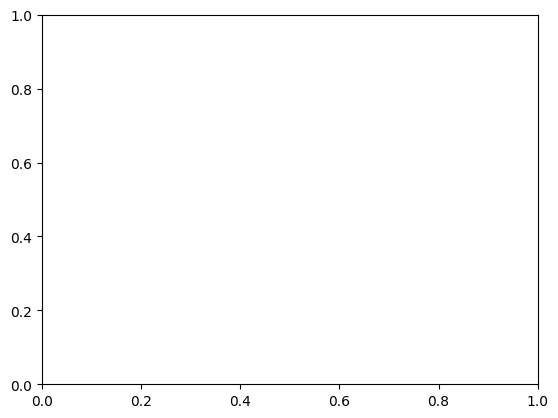

In [44]:
data.plot(kind="scatter", x="longitude", y="latitude")

<AxesSubplot: xlabel='longitude', ylabel='latitude'>

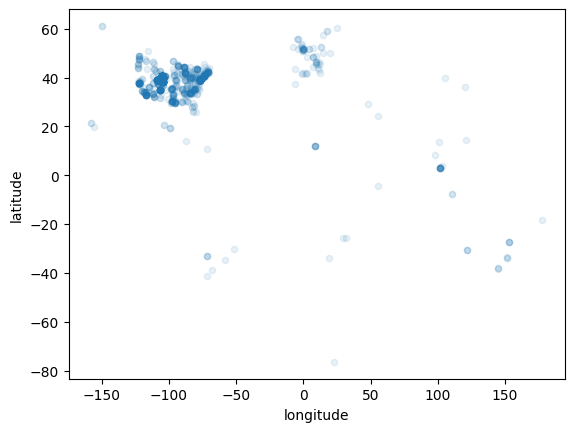

In [ ]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.1)

In [ ]:
import matplotlib.pyplot as plt

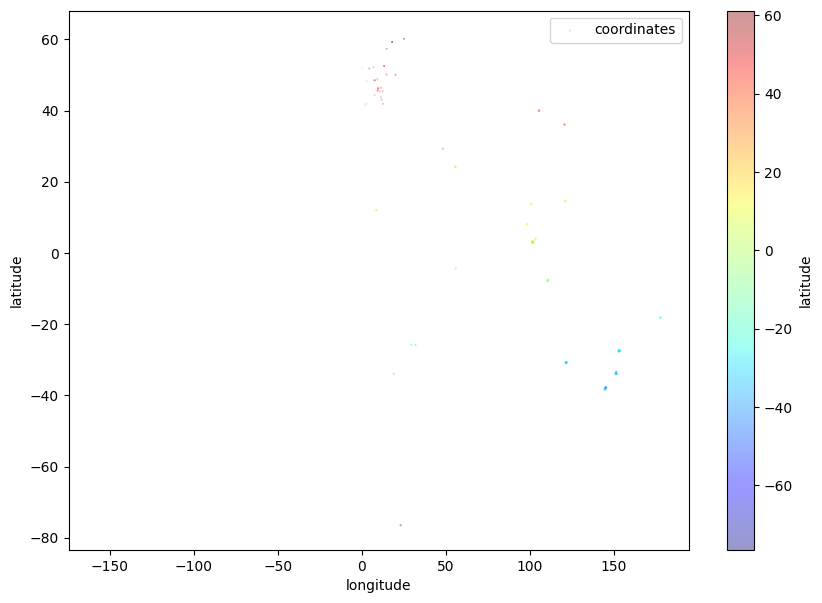

In [ ]:
data.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=data["longitude"]/100, label="coordinates", figsize=(10,7),
c="latitude", cmap=plt.get_cmap("jet"), colorbar=True,
) # c="median_house_value", 
plt.legend()